In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision.utils as tv_utils
from torchsummary import summary
from torchvision.models import resnet50
from torch import nn
from torchviz import make_dot, make_dot_from_trace

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import argparse
import time
import copy
from tqdm import tqdm
import os.path as osp

from datetime import datetime
import seaborn as sns
sns.set_style('darkgrid')

np.random.seed(0)
torch.manual_seed(0)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs/polyvore

In [4]:
class CompatibilityClassifier(nn.Module):
    def __init__(self):
        super(CompatibilityClassifier, self).__init__()
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(6, 32, kernel_size=5, stride=1, padding=2), #(6,256) / (6,32)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=.2),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  #(256,128) / (32, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=.2),
            
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  #(128,64) / (64, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=.2),

            # Many more convolutional layers need to be added to increase accuracy

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 1, kernel_size=56, stride=1, padding=0)    #(64,1)  / (32,1)  
        )
        
    def forward(self, x1, x2):
        x = torch.cat((x1, x2),1)
        output = self.cnn1(x)
        output = torch.sigmoid(output)
        output = output.reshape(-1)
        return output

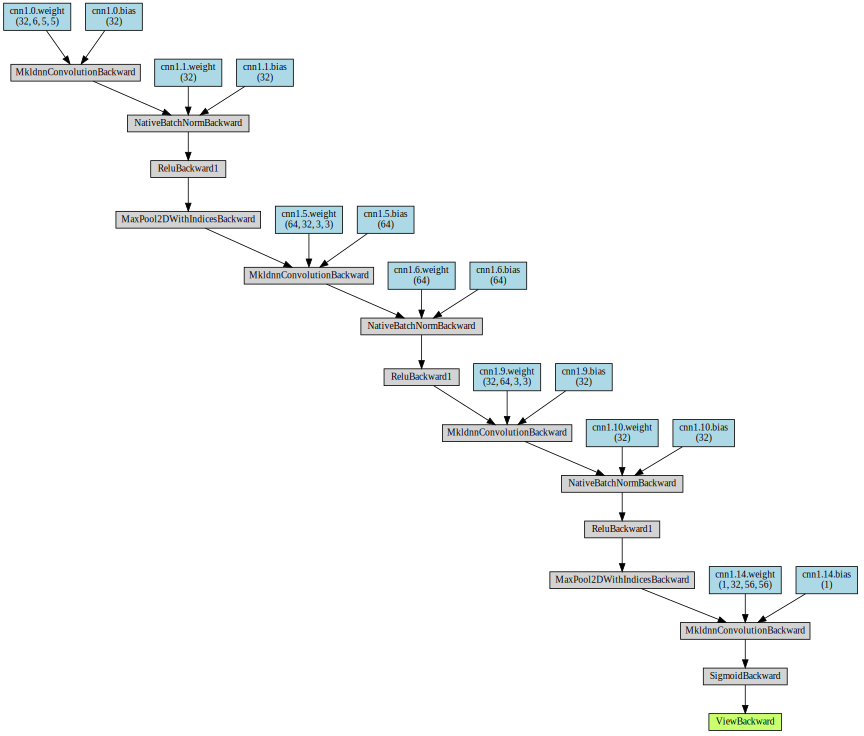

In [6]:
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
    
model = torch.load('compatibility-model.pth', map_location=map_location)

# x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
# out = model(x)
# make_dot(out)  # plot graph of variable, not of a nn.Module


x = torch.randn(1, 3, 224, 224).requires_grad_(False)
y = model(x,x)
#make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

In [11]:
!brew install graphviz
!pip install torchviz

NameError: name 'model' is not defined

In [19]:
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'/Users/harsha/Desktop/Temp/logs/polyvore/{ts}')

train_loss = [1.928301215171810,1.678498387336730,1.6272468566894500,1.5889683961868300,1.523438286781310,1.526465983390810,1.529483299255370,1.5164259481430100,1.5188186073303200,1.4996093320846600,1.4858977508544900,1.4745542621612500,1.461584529876710,1.4682045888900800,1.4539913749694800,1.4853878021240200,1.484366774559020,1.4803001880645800,1.4788283109664900,1.44045753479000,1.4711791276931800,1.4618953466415400,1.4609419107437100,1.461565613746640,1.42066499710083,1.4523520469665500,1.450212836265560,1.4501303434371900,1.4446686506271400,1.4059565877914400,1.4384468793869000,1.427880516052250,1.415197114944460,1.4004542541503900,1.384221863746640,1.4001091432571400,1.3943172407150300,1.3818621253967300,1.3732639074325600,1.36770763397200,1.3609492206573500,1.36439455986020,1.3512999439239500,1.345838131904600,1.336248688697820,1.3215798473358200,1.321390781402590,1.316140923500060,1.4349369096756000,1.2918099308013900]

train_acc = [47.0366325378418,52.193138122558600,53.47980499267580,54.31840133666990,54.84614944458010,55.27995681762700,55.46882629394530,55.71573257446290,55.96608352661130,57.27397918701170,57.368412017822300,57.4874382019043,57.58974075317380,57.81352996826170,58.88435745239260,58.20159912109380,58.156349182128900,58.18487548828130,58.37767791748050,58.47260284423830,59.491294860839800,59.76377487182620,59.651634216308600,59.77853012084960,60.81787872314450,60.968875885009800,60.98067855834960,60.08249282836910,60.09478759765630,60.566959381103500,60.5394172668457,60.58712387084960,60.788291931152300,60.777469635009800,61.566959381103500,61.5394172668457,61.58712387084960,61.788291931152300,61.777469635009800,61.81435775756840,61.67369079589840,61.76222229003910,61.992742919921900,61.15815734863280,62.08290481567380,62.20094680786130,62.10552978515630,62.165042877197300,61.99931640625,62.03193359375]

test_loss = [1.48702871799469,1.4214825630188000,1.417132019996640,1.3762198686599700,1.3940529823303200,1.380947232246400,1.3664395809173600,1.348492980003360,1.3771021366119400,1.3384310007095300,1.3614590167999300,1.3416788578033400,1.3284614086151100,1.3223882913589500,1.338722586631780,1.3275643587112400,1.3073307275772100,1.3339029550552400,1.3260200023651100,1.3144582509994500,1.284191370010380,1.2999438047409100,1.3035972118377700,1.2979960441589400,1.3019791841507000,1.2883069515228300,1.2624359130859400,1.281092643737790,1.3085638284683200,1.279934287071230,1.2682026624679600,1.2753703594207800,1.268319845199590,1.2591023445129400,1.2701743841171300,1.2755537033081100,1.2690513134002700,1.2961732149124100,1.2599304914474500,1.2623611688613900,1.271023154258730,1.2423279285430900,1.2654987573623700,1.265063762664800,1.2520960569381700,1.2682175636291500,1.229332447052000,1.2642971277236900,1.2701681852340700,1.2626100778579700]


test_acc = [56.4162712097168,58.37723159790040,59.08990478515630,59.70519256591800,60.470985412597700,60.25851058959960,61.01544952392580,60.49311828613280,60.94462585449220,60.91806411743160,60.9401969909668,61.059715270996100,61.608604431152300,61.84321212768560,61.152671813964800,61.343013763427700,61.55105972290040,61.52450180053710,61.59090042114260,61.99371337890630,62.49834060668950,61.785667419433600,62.26373291015630,62.18405532836910,61.49794006347660,62.63998794555660,62.65327072143560,62.635562896728500,61.8653450012207,62.12208557128910,62.648841857910200,62.49834060668950,62.56031036376950,62.92328643798830,62.75950622558590,62.542606353759800,62.67097473144530,62.31685256958010,62.42308807373050,62.879024505615200,62.905582427978500,63.13576126098630,62.449649810791000,63.14904022216800,62.812625885009800,62.72409439086910,63.30397033691410,63.08707046508790,62.31242370605470,62.91443634033200]

for i in range(50):
    writer.add_scalars('category/loss', {'train': train_loss[i]}, i+1)
    writer.add_scalars('category/accuracy', {'train': train_acc[i]}, i+1)

    writer.add_scalars('category/loss', {'test': test_loss[i]}, i+1)
    writer.add_scalars('category/accuracy', {'test': test_acc[i]}, i+1)
writer.close()


